In [1]:
import jax.numpy as np
from utils import MidpointNormalize, load_data
from jax import random, flatten_util, vjp, jvp, custom_vjp, jacfwd, jacrev, vmap, grad
from IFD_tsne import tsne_fwd
import jax
import matplotlib.pylab as plt
import seaborn as sns

In [7]:
# Pairwise squared Euclidean distance
def get_dists(Z):
    """
    Compute all pairwise distances of each data points z_i in Z.
    
    Params:
        Z: matrix with n rows. Each row is the z_i
        
    Return:
        All pairwise distances of each data points z_i in Z
    """

    
    diff = Z[:, :, None] - Z[:, :, None].T
    return (np.square(diff)).sum(1)

def perp_fn(i, beta_i, dists, perplexity_function):
    """
    Function that takes an index i, beta_i, and all pairwise distances of X
    and return the perplexity of p_{j|i} (Eq. 1 in the paper).
    """
    exp_dists = np.exp(-dists[i] / beta_i)
    exp_dists.at[i].set(0.)
    p_j_given_i = exp_dists / exp_dists.sum()

    perp_i = perplexity_function(p_j_given_i)

    return perp_i

def binary_search(perp, dists, perplexity_function):
    """
    Let beta_i := 2 \sigma_i^2. This function computes (beta_i) that achieve
    the desired perplexity.
    
    Params:                 
        perp: Desired perplexity value.
        
        dists: Pairwise squared Euclidean distances, stored in an (n x n)-matrix
        
        perplexity_function: A function that return the perplexity number given a probability vector
        
    Returns:
        betas: (n,) array of beta_i's 
    """    
    n = len(dists)
    betas = []
    
    for i in range(n):
        # Binary search
        min_beta, max_beta = 1e-10, 1e10

        for _ in range(1000):
            mid_beta = (min_beta + max_beta) / 2
            p_mid = perp_fn(i, mid_beta, dists, perplexity_function)

            if p_mid >= perp:
                max_beta = mid_beta
            else:
                min_beta = mid_beta

            # Close enough, use the current mid value
            if abs(p_mid - perp) < 1e-3:
                break
                
        betas.append(mid_beta)

    return np.array(betas)

def get_perplexity(p):
    """
    Returns the perplexity of p. See https://en.wikipedia.org/wiki/Perplexity
    
    Params:
        p: probability vector
        
    Return:
        A single number---the perplexity of p
    """
    entropy = -np.sum(p * np.log2(p + 1e-10))
    return 2**entropy


def get_beta(perp, dists_X):
    """
    Let beta_i := 2 \sigma_i^2. This function computes (beta_i) that achieve
    the desired perplexity.
    
    Params:                 
        perp: Desired perplexity value.
        
        dists_X: Pairwise squared Euclidean distances between points in X, stored in an (n x n)-matrix
                
    Returns:
        betas: (n,) array of beta_i's 
    """    
    return binary_search(perp, dists_X, get_perplexity)

def get_p_j_given_i(dists_X, perp):
    """
    Compute the conditional probabilities p_{j|i}'s
    
    Params
        dists_X: pairwise-distances matrix of X
        perp: the desired perplexity level (single number)

    Return:
        (n, n) matrix containing p_{j|i}'s
    """
    betas = get_beta(perp, jax.lax.stop_gradient(dists_X))

    p_j_given_i = np.exp(-dists_X / betas[None, :])
    p_j_given_i = p_j_given_i.at[np.diag_indices_from(p_j_given_i)].set(0.)
    return p_j_given_i / p_j_given_i.sum(1, keepdims=True)
    

def x2p(dists_X, perp):
    """
    Compute the joint probabilities p_ij's
    
    Params
        dists_X: pairwise-distances matrix of X
        perp: the desired perplexity level (single number)

    Return:
        (n, n) matrix P containing p_ij's
    """
    n = len(dists_X)
    p_j_given_i = get_p_j_given_i(dists_X, perp)
    p_i_given_j = p_j_given_i.T
    P = (p_j_given_i + p_i_given_j) / (2*n)
    return P

def y2q(dists_Y):    
    """
    Compute low-dimensional affinities q_ij
    
    Params
        dists_Y: (n, n) matrix containing all pairwise distances of elements of Y

    Return:
        (n, n) matrix Q containing q_ij's
    """
    Q = 1./(1. + dists_Y)
    Q = Q.at[np.diag_indices_from(Q)].set(0.)
    Q /= Q.sum()
    
    return Q

In [8]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30)
    dists_X = get_dists(X)
    P = x2p(dists_X, perplexity)
    P = np.maximum(P, 1e-12)
    dists_Y = get_dists(Y)
    Q = y2q(dists_Y)
    Q = np.maximum(Q, 1e-12)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [9]:
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9050, 50 iterations in 0.3151 sec
Iteration  100, KL divergence 0.8976, 50 iterations in 0.3037 sec
Iteration  150, KL divergence 0.9479, 50 iterations in 0.3071 sec
Iteration  200, KL divergence 0.9226, 50 iterations in 0.3030 sec
Iteration  250, KL divergence 0.8767, 50 iterations in 0.3061 sec
   --> Time elapsed: 1.54 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1788, 50 iterations in 0.3116 sec
Iteration  100, KL divergence 0.1638, 50 iterations in 0.3062 sec
Iteration  150, KL divergence 0.1637, 50 iterations in 0.3043 sec
Iteration  200, KL divergence 0.1637, 50 iterations in 0.3027 sec
Iteration 

In [10]:
KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener)

Array(0.17215644, dtype=float32)

In [11]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

In [12]:
v, w = np.linalg.eigh(H)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

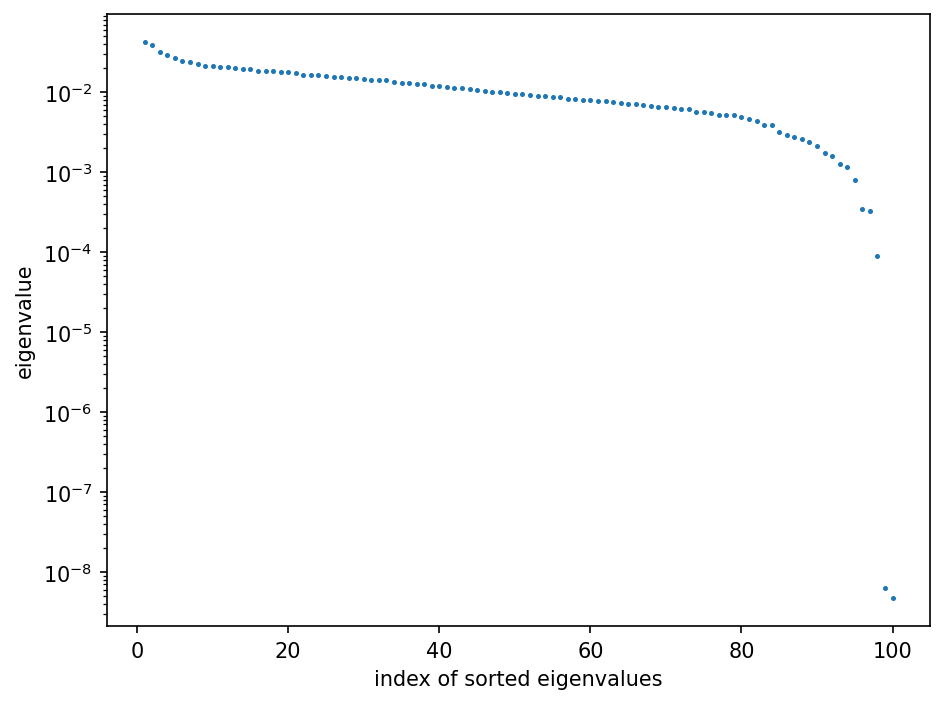

In [13]:
f = plt.figure()
plt.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), s=2)
#sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
plt.yscale('log')
plt.xlabel('index of sorted eigenvalues')
plt.ylabel('eigenvalue')
plt.tight_layout()

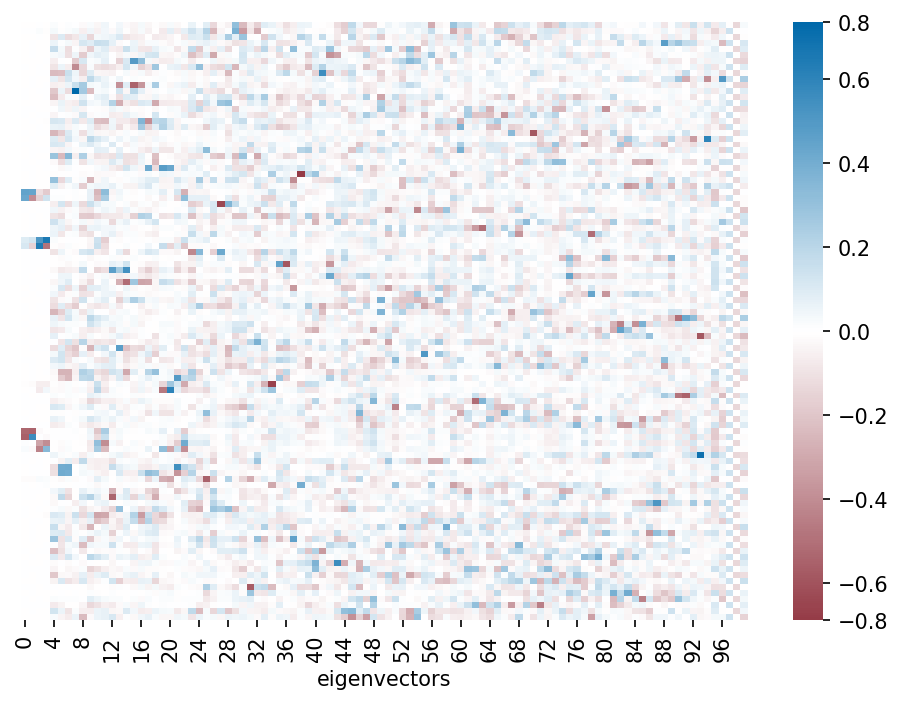

In [14]:
from tueplots.constants.color import palettes
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

f, ax1 = plt.subplots(1)
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax1, yticklabels=False)
ax1.set_xlabel('eigenvectors')
plt.tight_layout()

In [2]:
from simplified_tsne_jax import * 
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [77]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [79]:
v, w = np.linalg.eigh(H)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

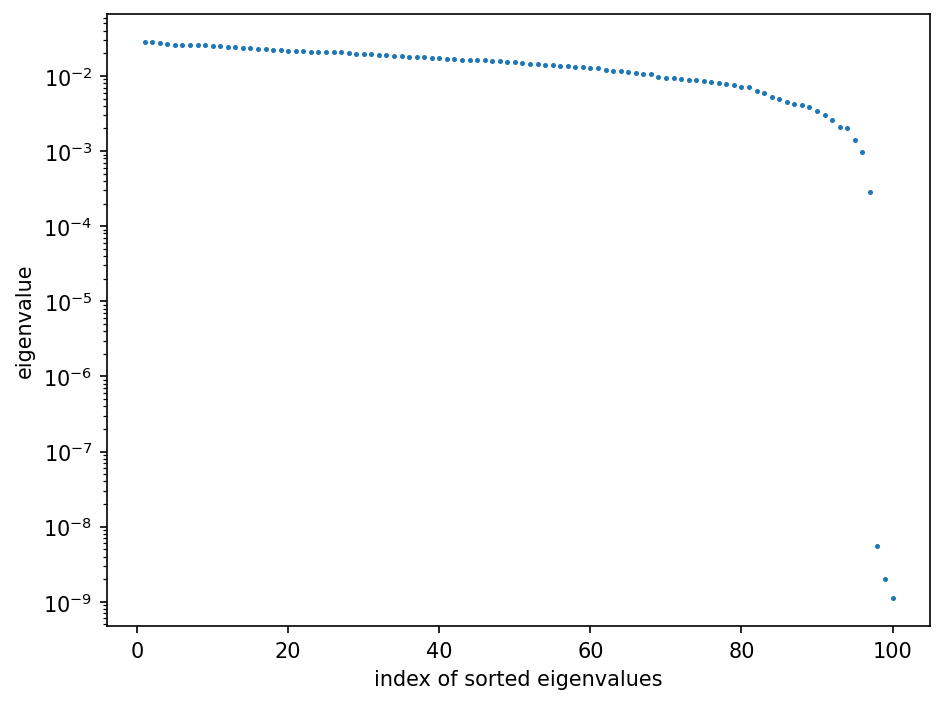

In [80]:
f = plt.figure()
plt.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), s=2)
#sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
plt.yscale('log')
plt.xlabel('index of sorted eigenvalues')
plt.ylabel('eigenvalue')
plt.tight_layout()

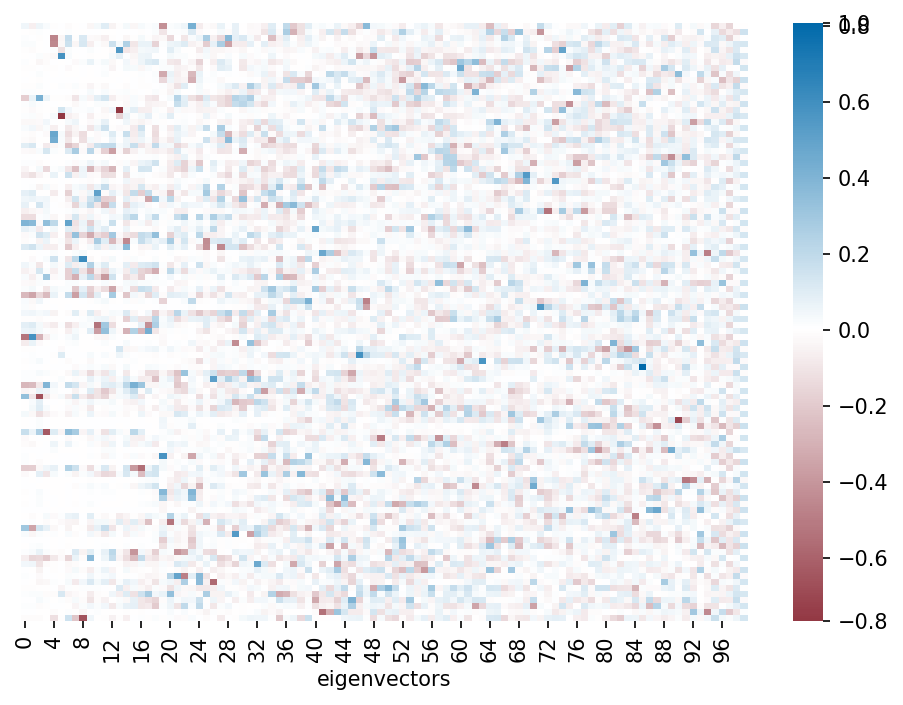

In [81]:
from tueplots.constants.color import palettes
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

f, ax1 = plt.subplots(1)
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax1, yticklabels=False)
ax1.set_xlabel('eigenvectors')
plt.tight_layout()

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, n_features=127, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.0322, 50 iterations in 0.5239 sec
Iteration  100, KL divergence 0.9489, 50 iterations in 0.3998 sec
Iteration  150, KL divergence 0.9039, 50 iterations in 0.3732 sec
Iteration  200, KL divergence 0.9917, 50 iterations in 0.3724 sec
Iteration  250, KL divergence 0.9602, 50 iterations in 0.3707 sec
   --> Time elapsed: 2.04 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.0145, 50 iterations in 0.3714 sec
Iteration  100, KL divergence 0.0145, 50 iterations in 0.3672 sec
Iteration  150, KL divergence 0.0145, 50 iterations in 0.3663 sec
Iteration  200, KL divergence 0.0145, 50 iterations in 0.3639 sec
Iteration 

In [4]:
#f = lambda X, Y: KL_divergence(X, Y, X_unflattener, Y_unflattener)
J_X_Y = jacfwd(jacfwd(KL_divergence, argnums=1), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener)
print(J_X_Y)

Computing pairwise distances...
Starting binary search
Entered binary search function
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
print(jacfwd(KL_divergence, argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener))

Computing pairwise distances...
Starting binary search
Entered binary search function
[0. 0. 0. ... 0. 0. 0.]
